In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle


In [38]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier



def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 1
tfdict = {"M5":0, "M15":1, "H1":2}
Xl, Xs, yl, ys = [], [], [], []
for btest in btests:
    print(btest.cfg.ticker)
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    for pos in btest.positions[1:]:
        f, _ = mw(pos.open_indx)
        fc = f.Close[:-2]/f.Close[-2]
        fo = f.Open[:-2]/f.Open[-2]
        fh = f.High[:-2]/f.High[-2]
        fl = f.Low[:-2]/f.Low[-2]
        fv = f.Volume[:-2]/f.Volume[-2] if f.Volume[-2] != 0 else f.Volume[:-2]*0
        if pos.dir == 1:
            Xl.append(np.hstack([fc, fo, fl, fh, fv, tfdict[btest.cfg.period]]))
            yl.append(pos.profit)
        else:
            Xs.append(np.hstack([2-fc, 2-fo, 2-fl, 2-fh, fv, tfdict[btest.cfg.period]])) 
            ys.append(pos.profit) 
        
Xs, Xl = np.array(Xs), np.array(Xl)
ys, yl = np.array(ys), np.array(yl)

# ids2add = np.random.choice(np.arange(Xs.shape[0]), size=Xl.shape[0] - Xs.shape[0])
# Xs = np.vstack([Xs, Xs[ids2add]])
# ys = np.hstack([ys, ys[ids2add]])
X = np.vstack([Xs, Xl])
y = np.hstack([ys, yl])
print(Xs.shape, Xl.shape, X.shape, ys.shape, yl.shape, y.shape)

SBER
ROSN
LKOH
GMKN
GAZP
SBER
ROSN
LKOH
GMKN
GAZP
SBER
ROSN
LKOH
GMKN
GAZP
(8120, 6) (8407, 6) (16527, 6) (8120,) (8407,) (16527,)


In [43]:
nitrers = 10
test_size = 0.2

profits, metrics = np.zeros((2, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    profs = y_test
    y_train = (y_train > 0).astype(int)
    y_test = (y_test > 0).astype(int)

    # scaler = StandardScaler() 
    # scaler.fit(X_train) 
    # X_train = scaler.transform(X_train) 
    # X_test = scaler.transform(X_test) 
    
    # X_add = X_train + np.random.random(X_train.shape)*0.1
    # X_train = np.vstack([X_train, X_add])
    # y_train = np.hstack([y_train, y_train])

    # # evals_result = {}
    # model = lgb.train(params=dict(objective="binary", 
    #                             # metric="auc",
    #                             # num_leaves=2, 
    #                             max_depth=5,
    #                             verbose=-1), 
    #                   train_set=lgb.Dataset(X_train, label=y_train),
    #                   valid_sets=[lgb.Dataset(X_test, label=y_test)],
    #                   num_boost_round=1000,
    #                   feval=lgb_f1_score,
    #                   # evals_result=evals_result,
    #                   # verbose_eval=False,
    #                   callbacks=[log_evaluation(-1)]
    #                   )
    # # lgb.plot_metric(evals_result, metric='f1')
    # p_train = model.predict(X_train)
    # p_test = model.predict(X_test)
    
    model = RandomForestClassifier(max_depth=10, n_estimators=50, class_weight="balanced")
    model.fit(X_train, y_train)
    p_train = model.predict_proba(X_train)[:, 1]
    p_test = model.predict_proba(X_test)[:, 1]
    
    threshold = np.percentile(p_train, 10)#np.mean(p_train)
    metrics[0, i] = f1_score(p_train > threshold, y_train)
    metrics[1, i] = f1_score(p_test > threshold, y_test)
    
    # plt.figure(figsize=(20, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(p_train[:100])
    # plt.plot(y_train[:100])
    # plt.plot([0, 100], [threshold, threshold])
    # plt.subplot(1, 2, 2)
    # plt.plot(p_test[:100])
    # plt.plot(y_test[:100])
    # plt.plot([0, 100], [threshold, threshold])

    profits[0, i] = profs.sum()
    profits[1, i] = (profs*(p_test>=threshold)).sum()
    print(f"{i:03} f1_train: {metrics[0, i]:4.2f}, f1_test: {metrics[1, i]:4.2f}, profit:{profits[0, i]:+6.1f} -> {profits[1, i]:+6.1f} {'OK' if profits[1, i] > profits[0, i] else '--'}")
    
prof_, prof = profits.mean(1)
print(prof_, prof, (prof - prof_)/abs(prof_))
prof_, prof = metrics.mean(1)
print(prof_, prof, (prof - prof_)/abs(prof_))

000 f1_train: 0.42, f1_test: 0.41, profit:+184.4 -> +207.1 OK
001 f1_train: 0.42, f1_test: 0.42, profit:+171.0 -> +190.7 OK
002 f1_train: 0.42, f1_test: 0.42, profit:+274.4 -> +287.8 OK
003 f1_train: 0.42, f1_test: 0.41, profit:+129.0 -> +160.6 OK
004 f1_train: 0.42, f1_test: 0.42, profit:+176.8 -> +181.3 OK
005 f1_train: 0.43, f1_test: 0.39, profit: +85.1 ->  +92.7 OK
006 f1_train: 0.42, f1_test: 0.41, profit:+192.4 -> +208.6 OK
007 f1_train: 0.42, f1_test: 0.42, profit:+249.1 -> +278.2 OK
008 f1_train: 0.42, f1_test: 0.43, profit:+327.4 -> +391.4 OK
009 f1_train: 0.42, f1_test: 0.42, profit: +95.0 -> +128.6 OK
188.46840358597856 212.6997358239405 0.1285697325223413
0.42250173393101587 0.4151972553378133 -0.01728863577727988


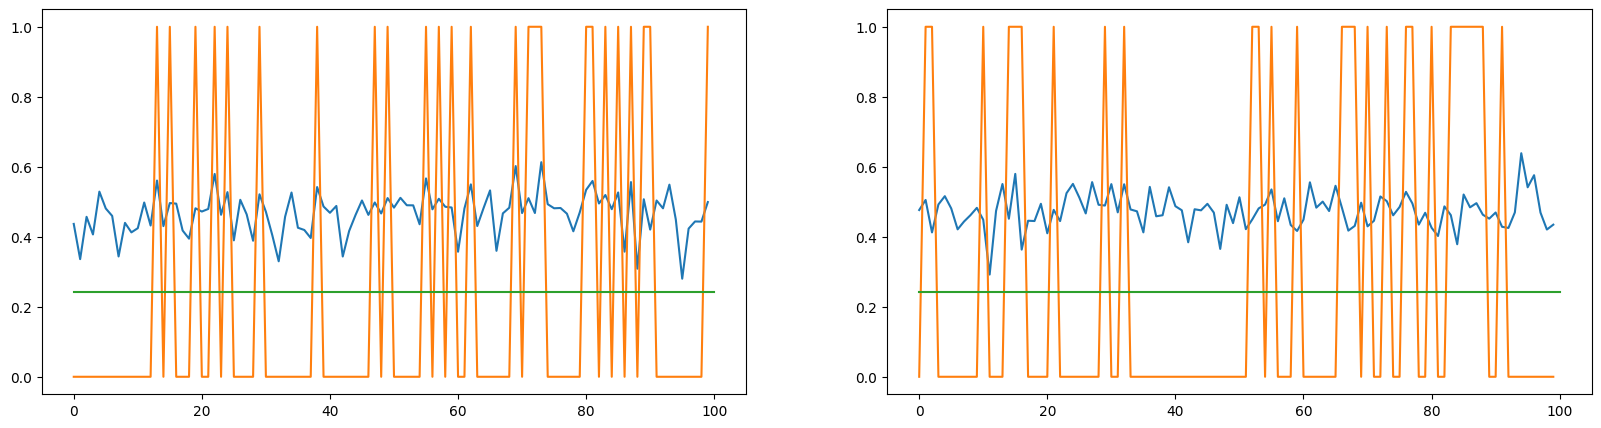

In [44]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100])
plt.plot(y_train[:100])
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100])
plt.plot(y_test[:100])
plt.plot([0, 100], [threshold, threshold])

In [36]:
for r in X_train[:3]:
    print(" ".join(map("{:6.4f}".format, r)))

0.9965 0.9989 0.9964 0.9992 0.4125 0.0000
0.9997 0.9999 1.0000 1.0002 0.8932 0.0000
0.9989 0.9989 0.9986 1.0001 2.2195 0.0000


In [37]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.2008 0.1891 0.1950 0.2030 0.1867 0.0254
